# Workflow

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import sys

sys.path.append('../hydra_TOD/')

from astropy.coordinates import EarthLocation, AltAz, SkyCoord
from astropy.time import Time, TimeDelta
import astropy.units as u
from utils import Leg_poly_proj, view_samples
from flicker_model import sim_noise, flicker_cov

## Scan

In [2]:
from simulation import * 

### 1. Define the two scans (rising and setting)
Tsky parameters and operators

In [13]:
# Get the timestream of beam centers (theta_c, phi_c) for each scan
_, theta_c_setting, phi_c_setting = sim_MeerKAT_scan(elevation=41.5, az_s=-60.3, az_e=-42.3, start_time_utc="2019-04-23 20:41:56.397")
bool_map_setting, _ = stacked_beam_map(theta_c_setting, 
                                       phi_c_setting, 
                                       FWHM=1.1, 
                                       NSIDE=64, 
                                       threshold = 0.0111) # This threshold cut off the beam directions outside the 3sigma region.

In [17]:

t_list, theta_c_rising, phi_c_rising = sim_MeerKAT_scan(elevation=40.5, az_s=43.7, az_e=61.7, start_time_utc="2019-03-30 17:19:02.397")
bool_map_rising, _ = stacked_beam_map(theta_c_rising, 
                                       phi_c_rising, 
                                       FWHM=1.1, 
                                       NSIDE=64, 
                                       threshold = 0.0111)

In [15]:
full_bool_map, pixel_indices = reduce_bool_maps_LOR([bool_map_setting, bool_map_rising])

Tsky_operator_setting = generate_Tsky_proj(full_bool_map, theta_c_setting, phi_c_setting, FWHM=1.1)
Tsky_operator_rising = generate_Tsky_proj(full_bool_map, theta_c_rising, phi_c_rising, FWHM=1.1)

In [18]:
len(pixel_indices)

sky_params = sky_vector(pixel_indices, 500, Nside=64, sky_model=None)

NameError: name 'sky_vector' is not defined

In [ ]:
# plt.figure(figsize=(12, 7))
# # Generate the equatorial coordinates of the pointings:
# ra_list = []
# dec_list = []

# plt.subplot(211)
# plt.plot(t_list, azimuths_setting, label='Setting')
# plt.plot(t_list, azimuths_rising, label='Rising')
# plt.xlabel('Time (s)')
# plt.ylabel('Azimuth (deg)')

# plt.subplot(212)
# plt.plot(t_list, elevation*np.ones_like(azimuths_setting))
# plt.xlabel('Time (s)')
# plt.ylabel('Elevation (deg)')


Total length of TOD:  2860
Total length of TOD:  2860


In [44]:

# # ---- Plot results ----
# # Generate a 2D plot of (RA, Dec) coordinates
# plt.figure(figsize=(12, 6))
# plt.scatter(equatorial_coords_setting.ra, equatorial_coords_setting.dec)
# plt.scatter(equatorial_coords_rising.ra, equatorial_coords_rising.dec)
# plt.xlabel("Right Ascension (degrees)")
# plt.ylabel("Declination (degrees)")
# plt.title("Sky Coordinates at Different Times")
# plt.show()


### Calibration source

In [ ]:
# from astropy.coordinates import SkyCoord

# # Using SIMBAD identifier
# # c = SkyCoord.from_name('3C 237')  
# c = SkyCoord.from_name('Pictor A')  
# print(f"RA: {c.ra.deg:.5f}°, Dec: {c.dec.deg:.5f}°")


RA: 79.95718°, Dec: -45.77885°


In [ ]:
# # Using coordinates from previous calculation
# c = SkyCoord.from_name('3C 237')  # RA/Dec from earlier cell

# # Create observation time array (example: 24-hour period in UTC)
# observation_time = Time.now() + np.linspace(0, 1, 100)*u.day  # 100 points over 24h

# # Get telescope location from TOD_sim class (assuming it's initialized)
# # From TOD_simulator.py: location = EarthLocation(lat=..., lon=..., height=...)
# altaz_frame = AltAz(obstime=observation_time, location=tod_sim.location)

# # Transform ICRS coordinates to Alt/Az
# altaz = c.transform_to(altaz_frame)

# # Plot results
# plt.figure(figsize=(12, 6))
# plt.plot(observation_time.datetime64, altaz.alt.deg, label='Elevation')
# plt.plot(observation_time.datetime64, altaz.az.deg, label='Azimuth')
# plt.xlabel('Time (UTC)')
# plt.ylabel('Degrees')
# plt.legend()
# plt.show()

### Beam setup

 Gaussian Beam (FWHM = 1.1 degrees)

$
\text{FWHM} = 2 \sigma \sqrt{2 \ln(2)}
$

In [ ]:
# Plot the beam in Mollweide projection
hp.mollview(sum_map, title=f"Sumed Gaussian Beam", unit="Arbitrary Units")
hp.graticule()

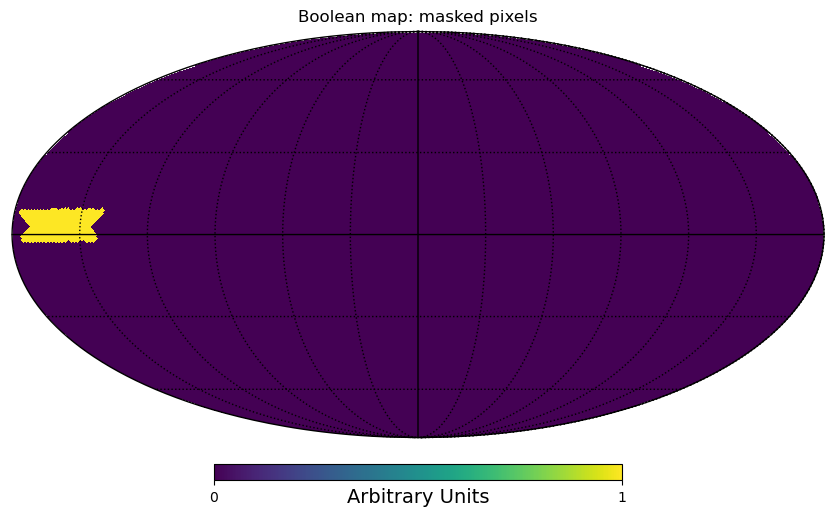

In [8]:
hp.mollview(full_bool_map, title=f"Boolean map: masked pixels", unit="Arbitrary Units")
hp.graticule()

### Sky temperature simulation

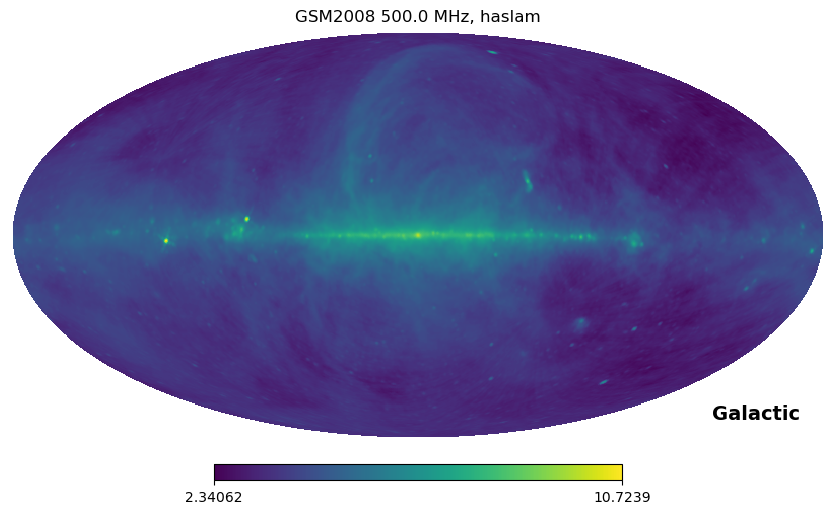

In [9]:
from pygdsm import GlobalSkyModel
gsm = GlobalSkyModel()
skymap = gsm.generate(500)
skymap = hp.ud_grade(skymap, nside_out=NSIDE)
true_Tsky = skymap[pixel_indices]
gsm.view(logged=True)



### Noise diode setup

In [10]:
# generate a vector of length ntime, every 10 elements there is a 1, the rest is 0
def generate_vector(ntime):
    vector = np.zeros(ntime)
    for i in range(0, ntime, 10):
        vector[i] = 1
    return vector

ndiode_proj = generate_vector(ntime)

T_ndiode = 10.0

### Receiver temperature

In [16]:
rec_proj = Leg_poly_proj(4, t_list)[:, :]
rec_params=np.array([4, 1, 0.5, 1])
plt.title("Receiver temperature")
plt.plot(rec_proj @ rec_params)

NameError: name 't_list' is not defined

### Gain and noise setup 

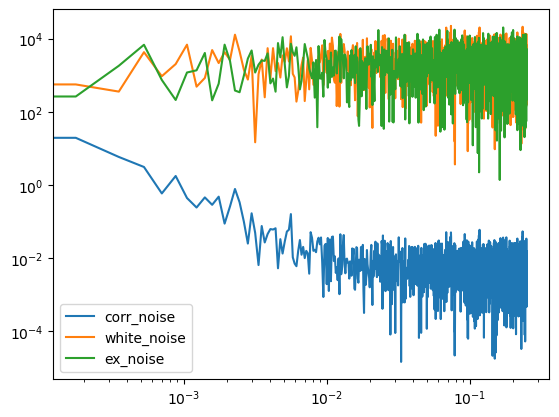

In [12]:
from numpy.linalg import cholesky

gain_proj = Leg_poly_proj(4, t_list)
gain_params=np.array([2, 0.5, 1.5, 0.5])*2
# mu0 = np.sin(2*np.pi*0.001*t_list)
mu0 = 0.
gains = gain_proj @ gain_params + mu0

f0, fc, alpha = 1e-4, 2e-5, 2.0
sigma_2 = 1/(4e5)

noise = sim_noise(f0, fc, alpha, t_list, n_samples=1, white_n_variance=sigma_2)[0]
covmat = flicker_cov(t_list, f0, fc, alpha, white_n_variance=sigma_2, only_row_0=False)
# invert the symmetric matrix, covmat
Ninv = np.linalg.inv(covmat)

aux_mat = cholesky(Ninv, upper=True)
white_noise = aux_mat @ noise

# Check if white noise is white: compare PSD of corr_noise and white_noise
psd_corr = np.abs(np.fft.rfft(noise))**2
psd_white = np.abs(np.fft.rfft(white_noise))**2
freqs = np.fft.rfftfreq(ntime, d=2)
# plot psd
plt.loglog(freqs, psd_corr, label='corr_noise')
plt.loglog(freqs, psd_white, label='white_noise')
ex_noise = np.random.randn(ntime)
psd_ex = np.abs(np.fft.rfft(ex_noise))**2
plt.loglog(freqs, psd_ex, label='ex_noise')

plt.legend()

In [15]:
inv_gains = 1/gains
p_gain_var = gain_proj.T @ (inv_gains[:, np.newaxis] * Ninv * inv_gains[np.newaxis, :]) @ gain_proj
p_gain_var = np.diag(np.linalg.inv(p_gain_var))
p_gain_var

array([0.00236494, 0.0005306 , 0.00136824, 0.00022486])

In [ ]:
plt.plot(gains)

In [16]:
from Tsys_sampler import Tsys_model

TOD_ndiode = T_ndiode*ndiode_proj
TOD_rec = rec_proj @ rec_params
Tsys_sim = Tsys_model([beam_proj, rec_proj, ndiode_proj], [true_Tsky, rec_params, T_ndiode])
TOD_sim = Tsys_sim * (1+noise) * gains 


ImportError: cannot import name 'Tsys_model' from 'Tsys_sampler' (/Users/zzhang/Workspace/flicker/Tsys_sampler.py)

Generate a sequence of time-ordered data for a scan of a receiver.

## Noise Parameter Sampler

In [17]:
from noise_sampler import noise_params_sampler, flicker_likeli_func
from mcmc_sampler import mcmc_sampler

In [ ]:
# logn_params = [np.log10(f0), np.log10(fc), alpha]
# boundaries = [[-12.,0.], [-12.,0.], [1.01,5.0]]
# log_likeli = flicker_likeli_func(t_list, TOD_sim, gains, Tsys_sim, wnoise_var=2.5e-6, boundaries=None)
# noise_samples_Jeff = mcmc_sampler(log_likeli, logn_params, p_std=0.05, 
#                     nsteps=50,  # steps for each chain
#                     n_samples=1,
#                     prior_func=None,
#                     num_Jeffrey=False,
#                     return_sampler=False)

# view_samples(noise_samples_Jeff, logn_params)


In [ ]:
# noise_samples_no_prior = noise_params_sampler(t_list, TOD_sim, gains, Tsys_sim, 
#                         sigma_2,
#                         nwalkers=6, 
#                         nsteps=100, 
#                         n_samples=300,
#                         log_scale=True, 
#                         prior_func=None,
#                         return_sampler=False)

# noise_samples = noise_samples_no_prior
# # Calculate statistics
# mean = np.mean(noise_samples, axis=0)
# std = np.std(noise_samples, axis=0)

# # Create subplots for four parameters
# fig, axes = plt.subplots(1, 3, figsize=(15, 6))
# axes = axes.ravel()

# logn_params = np.log10(f0), np.log10(fc), alpha
# params_names = ['log(f0)', 'log(fc)', 'alpha']
# for i in range(3):
#     # Plot histogram of samples for each parameter
#     axes[i].hist(noise_samples[:, i], bins=50, density=True, alpha=0.6, label='Samples')
    
#     # Plot true value line
#     axes[i].axvline(x=logn_params[i], color='r', linestyle='-', label='True Value', linewidth=2, alpha=0.7)
    
#     # Plot mean value line
#     axes[i].axvline(x=mean[i], color='g', linestyle='--', label='Mean')
    
#     # Add labels and title
#     axes[i].set_xlabel('Coefficient')
#     axes[i].set_ylabel('Density')
#     axes[i].set_title(f'Parameter {params_names[i]}')
#     axes[i].legend()
    
#     # Print numerical comparison for each parameter
#     print(f"\nGain Parameter {i+1}:")
#     print(f"True value: {logn_params[i]:.6f}")
#     print(f"Mean sampled: {mean[i]:.6f}")
#     print(f"Standard deviation: {std[i]:.6f}")

# plt.suptitle('Comparison of True Values, Mean for Noise Parameters (No Prior) (300 samples)')

# plt.tight_layout()
# plt.show()

## Gain Sampler Test

To test the gain sampler, we sample gain coefficients with given noise parameters and system parameters.

Iterative Generalised Least Squares (GLS) procedure.

In [18]:
from gain_sampler import gain_coeff_sampler

gain_samples = gain_coeff_sampler(TOD_sim, 
                    gain_proj, 
                    Tsys_sim, 
                    covmat, 
                    mu=mu0,
                    n_samples=4000,
                    tol=1e-20,
                    prior_cov_inv=None, 
                    prior_mean=None, 
                    solver=None)

view_samples(gain_samples, gain_params)


NameError: name 'TOD_sim' is not defined

In [19]:
inv_gains = 1/gains
p_gain_var = gain_proj.T @ (inv_gains[:, np.newaxis] * Ninv * inv_gains[np.newaxis, :]) @ gain_proj
p_gain_var = np.diag(np.linalg.inv(p_gain_var))
np.sqrt(p_gain_var)

array([0.04863061, 0.02303466, 0.03698967, 0.01499534])

## System temperature sampler

In [ ]:
from Tsys_sampler import Tsys_coeff_sampler, overall_operator

TOD_ndiode = T_ndiode*ndiode_proj

Tsys_proj = overall_operator([beam_proj, rec_proj])


Tsys_params = Tsys_coeff_sampler(TOD_sim, 
                       gains, 
                       Tsys_proj, 
                       covmat, 
                       n_samples=100,
                       mu=TOD_ndiode,
                       tol=1e-17,
                       prior_cov_inv=None, 
                       prior_mean=None, 
                       solver=None)


In [ ]:
Tsky_samples = Tsys_params[:,:num_pixels]
Tsky_mean = np.mean(Tsky_samples, axis=0)
Tsky_std = np.std(Tsky_samples, axis=0)
#Trec_samples = Tsys_params[:,num_pixels:]
#view_samples(Trec_samples, rec_params)

In [ ]:
# Compare true Tsky and sampled Tsky

plt.figure(figsize=(10, 6))
plt.plot(true_Tsky, label='True Tsky')
# Plot the mean of the samples, with error bars being the standard deviation
plt.errorbar(np.arange(len(true_Tsky)), Tsky_mean, yerr=Tsky_std, label='Sampled Tsky')
plt.ylim(5, 12)
plt.legend()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(true_Tsky, label='True Tsky')
# Plot the mean of the samples, with error bars being the standard deviation
plt.plot(Tsky_mean, label='Mean of samples')
plt.ylim(5, 12)
plt.legend()

In [ ]:
plt.plot(Tsky_std)

## Test the full Gibbs sampler

In [ ]:
from full_Gibbs_sampler import full_Gibbs_sampler_singledish 

In [ ]:
# read off the samples from Tsys_samples.npy
#

Tsys_samples = np.load('Tsys_samples.npy')

In [ ]:
Tsky_samples = Tsys_samples[:, :num_pixels]
Tmean = np.mean(Tsky_samples, axis=0)
Tstd = np.std(Tsky_samples, axis=0)



# plot the mean with error bars
# plt.errorbar(range(len(Tmean)), Tmean, yerr=Tstd, fmt='o', label='mean Tsky')
plt.plot(range(len(Tmean)), Tmean, label='mean Tsky')
plt.plot(range(len(Tmean)), true_Tsky, label='true Tsky', linestyle='--')
plt.ylim(5, 15)
plt.legend()



In [ ]:
# Show the healpix maps

true_map = np.zeros(NPIX, dtype=float)
sample_mean_map = np.zeros(NPIX, dtype=float)
sample_std_map = np.zeros(NPIX, dtype=float)

true_map[pixel_indices] = true_Tsky
sample_mean_map[pixel_indices] = Tmean
sample_std_map[pixel_indices] = Tstd


In [ ]:
# view the map using the saved colorbar

hp.mollview(true_map, title="True Tsky", unit="K", cmap='jet', min=5, max=15)

In [ ]:
hp.mollview(sample_mean_map, title="Mean Sampled Tsky", unit="K", cmap='jet', min=5, max=15)